# Part 3, Multilayer Perceptron Neural Network

In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import pandas as pd
import numpy as np
import sys
import h5py
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from keras.models import Sequential
from keras.models import save_model, load_model
from keras.layers.advanced_activations import PReLU
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.patches as mpatches


%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


We'll build a conceptually simple [feedforward neuron network](https://en.wikipedia.org/wiki/Feedforward_neural_network), or a multilayer perceptron (MLP), a network wherein connections between the units do not form a cycle. In feedforward networks, information flows from the input function `x` through intermediate (hidden) layers of fully-connected units to the output `y`.

**Terminology**. We use the terminology from Karpathy's [CS231n course](http://cs231n.github.io/neural-networks-1/). If a network consists of an input layer, a single hidden layer and an output layer, this is a **2-layer network** (we omit an input layer). If we add another hidden layer, we get a **3-layer network**, etc.

To compute the hidden layer values and to yield nonlinear transformations, we need to choose activation functions for our network. We also need to design the overall architecture of the network which includes the following assumptions: how many hidden layers our MLP should contain, how many units there should be in each layer, whether we use regularization techniques (e.g. dropout), which gradient descent optimizer to choose and how to initialize weights for units.

## A note on computational complexity
I had a hard time reducing the computational complexity of my MLPs. Finally, I decided to provide one of my production models (and methodology) I used at Kaggle, because it's somewhat unfair to compare the scores of different handicapped MLPs. Starting from Step 5, a special hardware (a modern GPU with enough memory) will be required to follow my computations. There are several ways to approach this issue:

* (obvious) Use a good machine and follow through all the steps. An alternative would be to start up a EC2 AWS instance, specifically, p2.xlarge, a GPU-compute optimized instance. I wrote down a short guideline for AWS as well as the bash script which sets the system up. An Ireland-based spot instance will cost about \$0.15-0.20 per compute-hour.

* Run pretrained models (just like in the XGBoost part). There is a number of benefits for doing this. First, Hyperopt is not deterministic, thus, it won't provide the same results that I got. Second, it took me dozens of hours to test various combinations with Hyperopt (and the search is not over yet). Third, I'll provide a handicapped version of my final model which will be used in the ensemble. It won't be bagged (less stable), it will be trained on a small amount of epochs, but it should demonstrate some decent score.

If you are not going to use pretrained models, change the following flag to `False`:

In [2]:
USE_PRETRAINED = True

## Framework

As with XGBoost, we start simple and train a basic MLP to set a baseline score for the next models. Then we determine which potential configurations may work better for us and run optimizations. Neural networks are known for having a large number of possible hyperparameters to tune. Having said that, we need to reduce the search space analytically and then start testing more prominent configurations.

Even more, neural networks can be easily overfitted, thus, a bias-variance tradeoff should be revisited. We'll pay a special attention to the monitoring of MLP training. While searching for a better model, a k-fold cross-validation will be the required technique to obtain a reasonable score estimate. 

The dataset will be split into the training and the validation subsets to introduce early stopping which terminates learning when the validation error starts to increase consistenly.

### Methodology
Methodologically, our process will be divided in the following steps:

* **Step 1.** Define a basic neural network configuration, train it, get a score which will be used as the lower margin of MLP performance.


* **Step 2.** Discuss the performance of a 2-layer model in context of bias-variance tradeoff and common issues: overfitting, instability due to high variance. 


* **Step 3.** Define a 3-layer model. Show the potential overfitting issues. Introduce cross-validation to prevent overfitting.


* **Step 4.** Experiment with hyperparameters manually, train several prominent configurations with decent scores, cross-validate models.


* **Step 5.** Introduce Hyperopt to test hyperparameters space and find out which are more robust.


* **Step 6.** After several rounds of Hyperopt, define and train the winning model, cross-validate the results.


### The use of Keras (frontend) and TensorFlow (backend)
To define and train neural networks, we'll use Keras, a _very_ straightforward and friendly library which works on top of TensorFlow (and Theano) with a minimum overhead. It's a great choice for experimentation and fast prototyping as it enables us to focus on the network configuration inself and not on the implementation of gradient descent, optimizers, backprop, details of weights initialization or activation functions. No doubt, we should have a solid understanding of how things work, but Keras is fine for our current purposes. 

Actually, Keras is so simple that it feels like cheating :)

We are going to approximate gradient over the batches of data since this method is more cost efficient (due to vectorized computations) and provides a faster convergence than to use a single training example at a time. Also, this is the default way to fit the model in Keras. We'll primarily use Adam gradient descent optimizer, though, any optimizer will be sufficient for our purposes (which is **not** true for Kaggle).


## Basic data preprocessing
We start with some data preprocessing. We need to convert categorical features with one-hot encoding and see how many dimensions we'll have afterwards.

In [3]:
train = pd.read_csv('train.csv')

cat_names = [c for c in train.columns if 'cat' in c]

train = pd.get_dummies(data=train, columns=cat_names)

features = [x for x in train.columns if x not in ['id','loss']]

train_x = np.array(train[features])

ntrain = train_x.shape[0]

# np.log(train['loss'] + 200) provides
# a better score, but let's keep it simple now
train_y = np.array(train['loss'])

print train_x.shape
print train_y.shape

(188318, 1153)
(188318,)


## Step 1: 2-layer model definition and training

Let's outline the architecture of our basic model. As we are training our first model, we start with just a single hidden layer architecture. Such an approach is recommended from [multiple](http://stackoverflow.com/questions/10565868/multi-layer-perceptron-mlp-architecture-criteria-for-choosing-number-of-hidde) [sources](http://www.deeplearningbook.org/contents/guidelines.html). The beauty of training a simple model is that it's harder to overfit, it trains faster and we get the results quicker.
> After choosing performance metrics and goals, the next step in any practical application is to establish a reasonable end-to-end system as soon as possible.

> *Ian Goodfellow and Yoshua Bengio and Aaron Courville, Deep Learning Book*

Here's our first architecture:

<table>
<tr><td>
<img src="http://cdn.rawgit.com/dnkirill/allstate_capstone/master/images/mlp1.svg"></td>
<td width="40%">
<p>This network contains just a single hidden layer with ReLU activation, which is connected with a single-unit output layer. All layers are dense, we don't implement dropout yet.</p>

<p><b>Input layer</b> consists of `train_x.shape[1] + 1` nodes: all our features and the bias term. Keras adds it automatically if we don't specifically set `bias=False` while initializing [Dense](https://github.com/fchollet/keras/blob/master/keras/layers/core.py) layer.</p>

<p>A single <b>hidden layer</b> consists of 128 nodes with ReLU activation function.</p>

<p><b>Output layer</b> is just a single unit (this is a regression problem) with `mean_absolute_error` objective we are trying to optimize. After computing the loss, the model starts calculating gradients and backpropagating them to input layer through the hidden layer.</p>
</td>
</tr></table>

Now it's time to define our model and start training. **The purpose of this section is to revisit the bias-variance tradeoff, but not to train the optimal model.**

Right now, we *won't* use cross-validation and just plot the learining curve using the validation subset taken from the training set. We'll return to CV later in this section.

My first assumption is that the nonlinear relationships in dataset will require several hidden layers and a single hidden layer model will struggle to fit this data. This will result in underfitting. In other words, our model is supposed to be biased. 

To test this out, we train a model with a single hidden layer, observe its performance and only then we go deeper.

In [4]:
def mlp_model():
    model = Sequential()
    model.add(Dense(128, input_dim=train_x.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

If we set verbose flag to 1, Jupyter may get stuck (text cell overflow). Let's pipeline stdout to a file. An easy way to monitor the training would be to `tail -f mlp_v1_out.txt` from command line.

In [5]:
_stdout = sys.stdout

In [6]:
# Model: mlp_v1
mlp = mlp_model()    

if USE_PRETRAINED: 
    
    # These .h5 models contain all the weights of a MLP
    # They are not really required for the project, but may
    # be useful to glance how trained models are saved
    mlp = load_model('pretrained/mlp_v1.h5')
    with open('pretrained/mlp_v1_hist.pkl', 'rb') as f:
        hist = pickle.load(f)
else:
    sys.stdout = open('mlp_v1_out.txt', 'w')
    fit = mlp.fit(train_x, train_y, validation_split=0.2, 
                  batch_size=128, nb_epoch=40, verbose=1)
    hist = fit.history

In [7]:
"Validation loss by epoch 40:", hist['val_loss'][-1]

('Validation loss by epoch 40:', 1178.3742217369372)

In [8]:
models_history = {}
models_history['mlp_v1'] = hist

Now we plot 1) the loss on training set throughout learning, 2) zoom in the last 20 epochs:

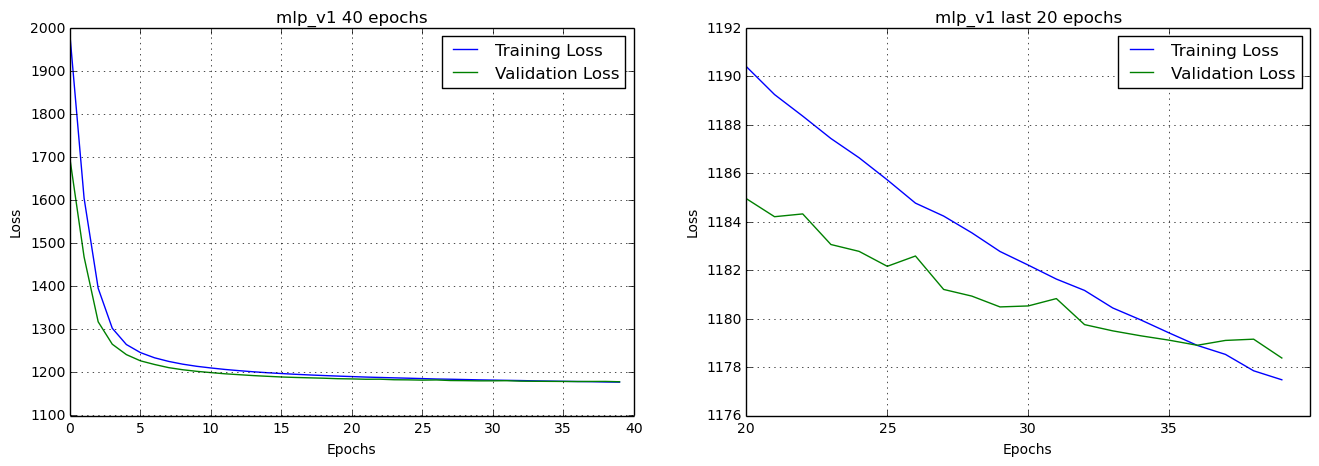

In [9]:
def plot_mlp_loss(history, title):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,5)

    ax1.set_title('{} 40 epochs'.format(title))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.plot(history['loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.legend()

    ax2.set_title('{} last 20 epochs'.format(title))
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.grid(True)
    ax2.set_xticklabels(range(20,40,5))
    ax2.plot(history['loss'][20:40], label='Training Loss')
    ax2.plot(history['val_loss'][20:40], label='Validation Loss')
    ax2.legend()
    
plot_mlp_loss(models_history['mlp_v1'], 'mlp_v1')

## Step 2: Performance of a 2-layer MLP
To my surprise, this model performed really well. From the plots we see that the validation error still decreases by the epoch 40. Such a model lacks extreme predictive power, but we still get many benefits:


* There are no signs of overfitting. This model naturally avoids overfitting and the difference between training and validation errors is small, which is a good feature.


* This model is quite stable (no excessive variance). I run it a number of times, and every time I got a predictable score.


* It's been fit rapidly. In a prodution environment, this feature can be crucial, e.g., we may have to frequently retrain models or our hardware may be slow enough to force us exclude complex models.


### Increasing the batch size
To speed the training up, we can increase the `batch_size` which will effectively decrease the amount of iterations of loss calculations per epoch. There is a tradeoff: we win on training time, but (due to a rougher gradient approximation) we lose on model's predictive power. Also, the further we increase the batch size, the less we win on training time.

Let's train the same model on `batch_size=256` and see the results.

In [10]:
mlp = mlp_model()

if USE_PRETRAINED:
    mlp = load_model('pretrained/mlp_v2.h5')
    with open('pretrained/mlp_v2_hist.pkl', 'rb') as f:
        hist = pickle.load(f)
else:
    sys.stdout = open('mlp_v2_out.txt', 'w')
    fit = mlp.fit(train_x, train_y, validation_split=0.2, 
                  batch_size=256, nb_epoch=40, verbose=1)
    hist = fit.history

In [11]:
models_history['mlp_v2'] = hist

In [12]:
"Validation loss by epoch 40:", hist['val_loss'][-1]

('Validation loss by epoch 40:', 1181.5385966207784)

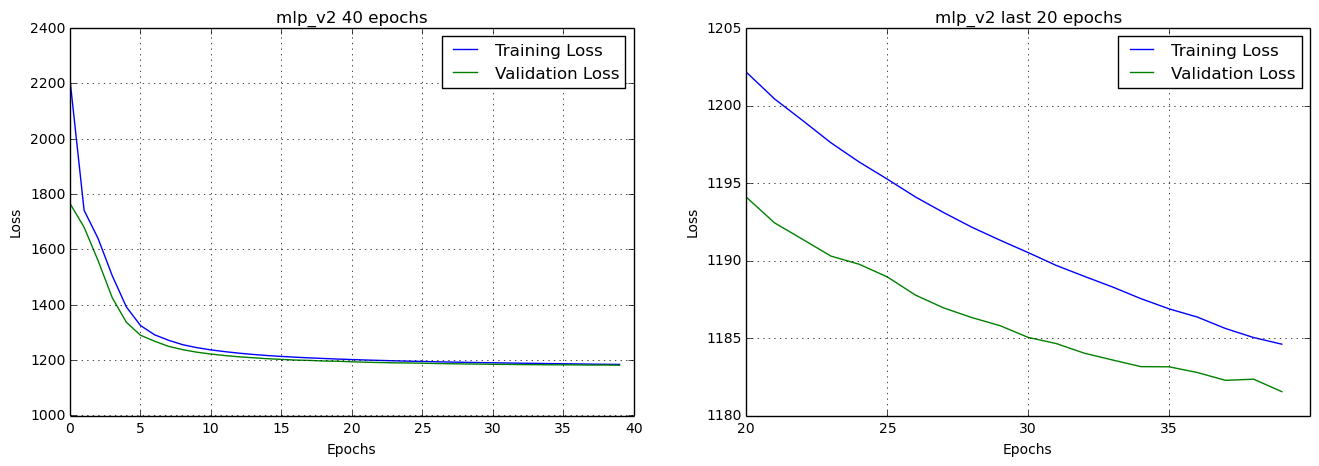

In [13]:
plot_mlp_loss(models_history['mlp_v2'], 'mlp_v2')

We see, we got a slight performance drop when we increased the batch size. Depending on your current machine, there may or may not be benefits in doing this (different machines showed different results). The final decision, of course, depends on the task we need to accomplish. In this capstone, I'll switch back to `batch_size=128`.

### Increasing the number of units in the hidden layer

Next, we'll test a little stronger model by adding more units to the hidden layer (doubling the amount of units from 128 to 256). Do we get an improvement on the validation set?

In [14]:
def mlp_model():
    model = Sequential()
    model.add(Dense(256, input_dim=train_x.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [15]:
mlp = mlp_model()

if USE_PRETRAINED:
    mlp = load_model('pretrained/mlp_v3.h5')
    with open('pretrained/mlp_v3_hist.pkl', 'rb') as f:
        hist = pickle.load(f)
else:
    sys.stdout = open('mlp_v3_out.txt', 'w')
    fit = mlp.fit(train_x, train_y, validation_split=0.2, 
                  batch_size=128, nb_epoch=40, verbose=1)
    hist = fit.history

In [16]:
models_history['mlp_v3'] = hist

In [17]:
"Validation loss by epoch 40:", hist['val_loss'][-1]

('Validation loss by epoch 40:', 1175.2881276301641)

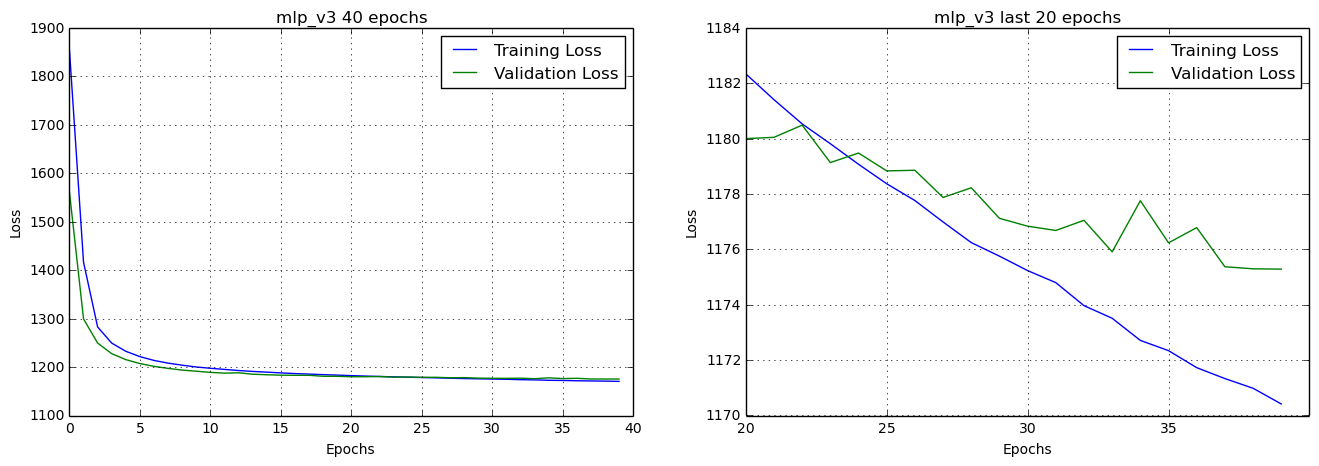

In [18]:
plot_mlp_loss(models_history['mlp_v3'], 'mlp_v3')

We notice a small improvement both in training loss and in validation loss if we compare the plots of `mlp_v1` and `mlp_v3`. The improvement is not drastic, but it's visible.

Moreover, I also trained the 1024-unit network and got peculiar results:

* It can be overfitted, starting from epoch 115.


* Validation loss reached 1145 at the lowest point.


* 3-fold CV showed MAE = 1171 (by epoch 120). This is not the worst performance for a single unbagged model when we consider that this is a one-layer network with a limited nonlinearity.


I haven't yet introduced CV, but I calculated a 3-fold CV (the function will be presented soon) for `mlp_v1` regardless this fact: MAE = 1190.73 (40 epochs), 1186.55 (120 epochs, no visible overfitting). As we expected, the predictive power of a 128-unit model is quite limited.

We could increase the number of units even further, and, according to the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), we approximate any continuous function in Euclidean space. From the practical point of view, this is not the best option: the number of units should be exponentially larger.

To conclude this section and to move forward, I'd like to highlight the "start with the simplest" approach. As we've just seen, even a simple one hidden layer network shows a decent performance.

## Step 3: 3-layer model: CV and overfitting demo

<table>
<tr><td>
<img src="http://cdn.rawgit.com/dnkirill/allstate_capstone/master/images/mlp2.svg"></td>
<td width="35%">
<p>This network contains two hidden layers with ReLU activation. The second hidden layer is connected with a single-unit output layer. All layers are dense.</p>

<p><b>Input layer</b> consists of `train_x.shape[1] + 1` nodes: all our features and the bias term.</p>

<p><b>Both hidden layers</b> consist of units with ReLU activation function.</p>

<p><b>Output layer</b> is just a single unit with `mean_absolute_error` objective we are trying to optimize.</p>

<p><b>Cross-validation</b> becomes essential since we reach the point where the model becomes powerful enough to capture nonlinear relationships in training set and easily overfit. We should be able to detect it with CV.</p>

<p>To prevent overfitting, we introduce <b>dropout</b> and randomly nullify activations of units in hidden layers.</p>
</td>
</tr></table>

### Cross-validation
First, we introduce cross-validation. We'll use a 3-fold CV which is just a rough estimate of a better 5-fold or 10-fold CV. On the other hand, we just need to capture trends and are not very interested in the maximum precision. On Kaggle, I use 5-fold CV.

There are several points to be mentioned:

* As usual, cross-validation is built on top of `cross_validation.KFold` class from `sklearn`.


* To prevent errors, we require passing a _function_ of a model, not the object itself. Otherwise, we may find ourselves in an awkward position where we train the same model on different folds.


* We add early stopping with a small value of patience. After a number of trials, `patience=5` was found quite a reasonable value (my production model uses `patience=8`, though).

In [19]:
def cross_validate_mlp(mlp_func, nfolds=3):
    folds = KFold(len(train_y), n_folds=nfolds, shuffle=True, random_state = 31337)
    val_scores = np.zeros((nfolds,))
    for k,(train_index, test_index) in enumerate(folds):
        xtr = train_x[train_index]
        ytr = train_y[train_index]
        xte = train_x[test_index]
        yte = train_y[test_index]
        mlp = mlp_func()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)
        fit = mlp.fit(xtr, ytr, validation_split=0.2, batch_size=128, 
                      nb_epoch=30, verbose=1, callbacks=[early_stopping])
        pred = mlp.predict(xte, batch_size=256)
        score = mean_absolute_error(yte, pred)
        val_scores[k] += score
        print 'Fold {}, MAE: {}'.format(k, score)
    avg_score = np.sum(val_scores) / float(nfolds)
    print '{}-fold CV score: {}'.format(nfolds, avg_score)
    return avg_score

### Danger of overfitting
Neural (especially deep) networks are known for their tendency to overfitting. The more nonlinear transformations we allow our network to make (by adding more hidden layers), the easier our model may get overfit.

To show that overfitting is very real and easily achievable, we train a model without any regularization. Basically, we just add one more layer to our previous models. We increase the number of units to visualize overfitting better, but the same result can be obtained without such an increase.

We split training set into training and validation. For now, I decided to use `train_test_split` from `sklearn`, though we could use `validation_split` parameter from `Sequential.fit` method again.

In [20]:
xtr, xte, ytr, yte = train_test_split(train_x, train_y, test_size=0.25, random_state=31337)

We initialize a wide3-layer model with 1024-512 units in hidden layers:

In [21]:
def mlp_model():
    model = Sequential()
    model.add(Dense(1024, input_dim=xtr.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

We train the model and visualize the results:

In [22]:
mlp = mlp_model()

if USE_PRETRAINED:
    
    # This model weights 20 MB and I decided to exclude it
    # from the repository. If you still need it, you can download it from S3:
    
    # !wget https://s3-eu-west-1.amazonaws.com/kd-allstate/mlp_v4.h5 -d pretrained
    # mlp = load_model('pretrained/mlp_v4.h5')
    
    with open('pretrained/mlp_v4_hist.pkl', 'rb') as f:
        hist = pickle.load(f)
else:
    sys.stdout = open('mlp_v4_out.txt', 'w')
    fit = mlp.fit(xtr, ytr, batch_size=128, validation_data=(xte,yte),
                  nb_epoch=40, verbose=1)
    hist = fit.history

In [23]:
models_history['mlp_v4'] = hist
sys.stdout = _stdout

If we print a training loss after 40 epoch, we'll see an alarmingly good score:

In [24]:
print 'Training loss by epoch 40:', models_history['mlp_v4']['loss'][-1]

Training loss by epoch 40: 823.149182086


But the validation loss is out of sync with the training loss:

In [25]:
print "Validation loss by epoch 40:", hist['val_loss'][-1]

Validation loss by epoch 40: 1239.28444009


We clearly see the overfitted model when we plot loss on training and validation sets. One of the effects of overfitting is the increasing gap between validation and training errors, as we see from the plots below:

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


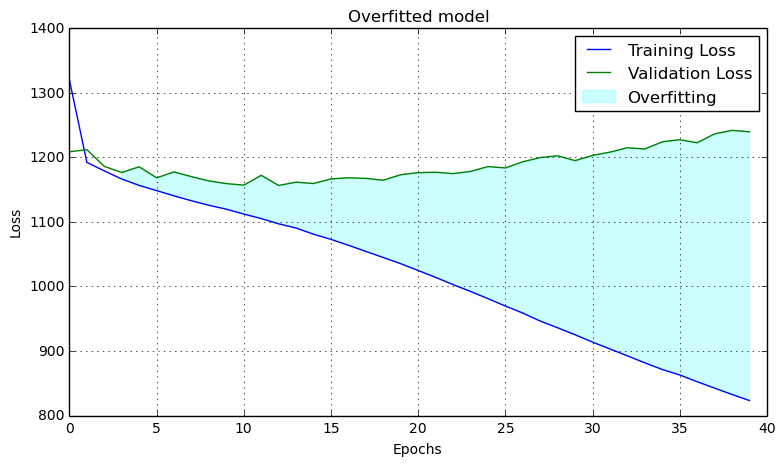

In [26]:
plt.figure(figsize=(9,5))
plt.title('Overfitted model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt1, = plt.plot(models_history['mlp_v4']['loss'], label='Training Loss')
plt2, = plt.plot(models_history['mlp_v4']['val_loss'], label='Validation Loss')
fill = plt.fill_between(range(3,40,1),models_history['mlp_v4']['loss'][3:],
                 models_history['mlp_v4']['val_loss'][3:], alpha=0.2, color='cyan')

overfit_legend = mpatches.Patch(color='cyan', alpha=0.2, label='Overfitting')
handles = [plt1, plt2, overfit_legend]
plt.legend(handles, ['Training Loss','Validation Loss','Overfitting'])

plt.show()

Such models will fail to generalize. To cope with overfitting, we have several regularization techniques in our toolbox:

* Dropout


* Batch Normalization


* Early Stopping


* Running the model several times and bagging results.

## Step 4: List hyperparameters. Manually cross-validating models

Let's now step back and reevaluate different hyperparameters we have to decide on:

* **Number of hidden layers**: we now have two hidden layers, we pushed a single hidden layer model to its maximum, but we still have a possibility to train deeper models.


* **Number of hidden units**: both in hidden layer #1 and hidden layer #2.


* **Dropout rates**: both in hidden layer #1 and hidden layer #2.


* **Activation function**. We will consistently use ReLU throughout the project. I tested both ReLU and [Parametric ReLU](https://arxiv.org/abs/1502.01852) (a generalization upon ReLU which beat ReLU score in ImageNet-2012 classification), but I didn't find any significant score increase with PReLU.


* **Early stopping parameters**: number of epochs, value of patience. We'll limit the number of epochs to 30 to speed up training time. In my production model, I used 70 epochs with `patience=8`.


* **Gradient descent optimizer**: we mostly use ADAM, but my final model uses [Adadelta](http://sebastianruder.com/optimizing-gradient-descent/index.html#adadelta).


* **Weights initialization**. Glorot uniform is the default, but my final model uses glorot normal. This is the result of Hyperopt search. 


* **Learning rate, learning rate decay**. We'll keep them default.


Actually, there are even more considerations we should take, but the point of listing hyperparameters is to show it's not enough to just add another layer, some dropout and think the work is done.

Nevertheless, we start by doing just this: defining several 3-layer configurations, doing a manual CV over them and picking the one with the best CV score.

**Configurations:**

| Model Name | Hidden Layers | Hidden Layer #1 Units | Hidden Layer #2 Units | Hidden Layer #1 Dropout | Hidden Layer #2 Dropout |
|------------|---------------|-----------------------|-----------------------|-------------------------|-------------------------|
| mlp_v5     | 2             | 64                    | 16                    | 0.3                     | 0.2                     |
| mlp_v6     | 2             | 128                   | 32                    | 0.4                     | 0.3                     |
| mlp_v7     | 2             | 256                   | 64                    | 0.5                     | 0.4                     |

In [27]:
def mlp_v5():
    model = Sequential()
    model.add(Dense(64, input_dim=train_x.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

def mlp_v6():
    model = Sequential()
    model.add(Dense(128, input_dim=train_x.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

def mlp_v7():
    model = Sequential()
    model.add(Dense(256, input_dim=train_x.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [28]:
# Cross-validation and score evaluation
scores = {}

if USE_PRETRAINED:
    with open('pretrained/mlp_v5_v6_v7_scores.pkl', 'rb') as f:
        scores = pickle.load(f)
else:
    sys.stdout = open('mlp_v5_v6_v7_out.log', 'w')
    for i, model_func in enumerate([mlp_v5, mlp_v6, mlp_v7]):
        score = cross_validate_mlp(model_func)
        scores[model_func.__name__] = score
    sys.stdout = _stdout

In [29]:
scores

{'mlp_v5': 1193.1136604667843,
 'mlp_v6': 1180.3518637720078,
 'mlp_v7': 1174.283208544334}

Your performance may be different, but I got the following scores:

`
{'mlp_v5': 1193.1136604667843,
 'mlp_v6': 1180.3518637720078,
 'mlp_v7': 1174.283208544334}
`
 
The best model of these three (`mlp_v7`) shows a worse score (1174), than our single layer model with 1024 units (1171)! We now see that it takes **much** more effort to train a deeper model. Though, we shouldn't forget that we specifically limited our training to 30 epochs now (which we didn't for that single hidden layer model).

After CV, we list two baseline configurations:

* **2-layer model**. Hidden units: 1024. Epochs: 115.
* **3-layer model**. Hidden units: 256, 64. Dropout: 0.5, 0.4. Epochs: 30.

## Step 5: Hyperopt MLP hyperparameters tuning

After doing a CV over manually chosen models, we may want to automate this process and search over many more combinations. Unfortunately, there's no fast way to tune the hyperparameters of a neural network. 

To search over the space of hyperparameters, I introduce [Hyperopt](https://github.com/hyperopt/hyperopt), a model-agnostic library for advanced parallel hyperparams optimization. Hyperopt represents a Bayesian approach to optimization: the library uses the prior knowledge to make more intelligent assumptions what combination of parameters to try next.

I'll just briefly touch upon it, because it may and will take an enormous amount of time to train and validate multiple combinations of hyperparams via Hyperopt. Anyway, it's a reliable and popular library which is heavily (ab)used on Kaggle.

My methodology is based on [an post on fastml.com blog](http://fastml.com/optimizing-hyperparams-with-hyperopt/), which brings a 3-step process:

1. Describe the search space: all hyperparameters and their possible values.

2. Implement a function to minimize (our Keras model which minimizes the loss).

3. Analyze and pick scores.

### 4 versions of Hyperopt search

This Hyperopt code is for demo only. I commented out the code which actually starts Hyperopt.

Running the following optimization will literally require **days** on any ordinary PC. To test that the code works, uncomment the lines with `fmin` function calls.  I'd recommend running it and seeing its output from a command-line: 

`$ tail -f hyperopt_v1.log`

Then you should interrupt kernel and move on.

In [30]:
# We need to define the search space for Hyperopt
# Conditionals are used to maintain the structure of the network
# Each hidden layer to the right has less units than the previous one

# VERSION 1: two hidden layers, wide networks.

# Describing the search space
space = {'hidden1': hp.choice('hidden1', [
            {
                'hidden1_units': 256,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': 128
                        }
                    ]),
                'hidden1_units': 512,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': hp.choice('hidden2_units', [128,256])
                        }
                    ]),
                'hidden1_units': 768,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': hp.choice('hidden2_units', [128,256,512]),
                        }
                    ]),
                'hidden1_units': 1024,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': hp.choice('hidden2_units', [128,256,512,768]),
                        }
                    ])
            }]), 
        'hidden1_dropout': hp.uniform('hidden1_dropout', 0.1,0.6), 
        'hidden2_dropout': hp.uniform('hidden2_dropout', 0.1,0.5)}

# Implementing a function to minimize
def hyperopt_search(params):
    print 'Model Testing:', params
    def mlp_model():
        model = Sequential()
        model.add(Dense(params['hidden1']['hidden1_units'], input_dim=train_x.shape[1]))
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden1_dropout']))
        
        model.add(Dense(params['hidden1']['hidden2']['hidden2_units']))
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden2_dropout']))
        
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam', metrics = ["mae"])
        return model
    
    cv_score = cross_validate_mlp(mlp_model)
    return {'loss': cv_score, 'status': STATUS_OK}

# Run the optimization and see the results
sys.stdout = open('hyperopt_v1.log', 'w')
trials = Trials()

# UNCOMMENT THE NEXT LINE TO LAUNCH HYPEROPT:
# best = fmin(hyperopt_search, space, algo=tpe.suggest, max_evals = 50, trials=trials)

In [31]:
# VERSION 2. Insights:
# – increase the lower and upper bounds of dropout,
# — the wider network doesn't seem to work well.

# Describing the search space
space = {'hidden1': hp.choice('hidden1', [
            {
                'hidden1_units': 128,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': 64
                        }
                    ]),
                'hidden1_units': 256,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': hp.choice('hidden2_units', [32,64,128])
                        }
                    ]),

                'hidden1_units': 512,
                'hidden2': hp.choice('hidden2', [
                        {
                            'hidden2_units': hp.choice('hidden2_units', [32,64,128,256])
                        }
                    ])
            }]), 
        'hidden1_dropout': hp.uniform('hidden1_dropout', 0.3,0.7), # Several rounds of hyperopt
        'hidden2_dropout': hp.uniform('hidden2_dropout', 0.2,0.6)} # resulted in these values

# Implementing a function to minimize
def hyperopt_search(params):
    print 'Model Testing:', params
    def mlp_model():
        model = Sequential()
        model.add(Dense(params['hidden1']['hidden1_units'], input_dim=train_x.shape[1]))
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden1_dropout']))
        
        model.add(Dense(params['hidden1']['hidden2']['hidden2_units']))
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden2_dropout']))
        
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam', metrics = ["mae"])
        return model
    
    cv_score = cross_validate_mlp(mlp_model)
    return {'loss': cv_score, 'status': STATUS_OK}

# Run the optimization and see the results
sys.stdout = open('hyperopt_v2.log', 'w')
trials = Trials()

# UNCOMMENT THE NEXT LINE TO LAUNCH HYPEROPT:
# best = fmin(hyperopt_search, space, algo=tpe.suggest, max_evals = 50, trials=trials)

In [32]:
# VERSION 3. Insights:
# — models with two hidden layers and 256-128 units configuration work well
# — let's optimize the number of units in layers with a more precise step

# Describing the search space
space = {'hidden1_dropout': hp.choice('hidden1_dropout', np.linspace(0.4,0.6,20)),
        'hidden2_dropout': hp.choice('hidden2_dropout', np.linspace(0.2,0.5,10)),
         'hidden1_units': hp.choice('hidden1_units', np.linspace(300,550,30,dtype='int16')),
         'hidden2_units': hp.choice('hidden2_units', np.linspace(100,300,30,dtype='int16'))
        }

# Implementing a function to minimize
def hyperopt_search(params):
    print 'Model Testing:', params
    def mlp_model():
        model = Sequential()
        model.add(Dense(params['hidden1_units'], input_dim=train_x.shape[1]))
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden1_dropout']))
        
        model.add(Dense(params['hidden2_units']))
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden2_dropout']))

        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam', metrics = ["mae"])
        return model
    
    cv_score = cross_validate_mlp(mlp_model)
    return {'loss': cv_score, 'status': STATUS_OK}

# Run the optimization and see the results
sys.stdout = open('hyperopt_v3.log', 'w')
trials = Trials()

# UNCOMMENT THE NEXT LINE TO LAUNCH HYPEROPT:
# best = fmin(hyperopt_search, space, algo=tpe.suggest, max_evals = 50, trials=trials)

In [33]:
# VERSION 4. Insights:
# – why not to test 4-layer architectures?
# — we need to introduce new optimizers
# — adding batch normalization (https://arxiv.org/abs/1502.03167)

# Describing the search space
space = {'hidden1_dropout': hp.choice('hidden1_dropout', np.linspace(0.4,0.6,20)),
        'hidden2_dropout': hp.choice('hidden2_dropout', np.linspace(0.2,0.5,10)),
        'hidden3_dropout': hp.choice('hidden3_dropout', np.linspace(0.1,0.5,10)),
         'hidden1_units': hp.choice('hidden1_units', np.linspace(300,550,30,dtype='int16')),
         'hidden2_units': hp.choice('hidden2_units', np.linspace(100,300,30,dtype='int16')),
         'hidden3_units': hp.choice('hidden3_units', np.linspace(20,80,30,dtype='int16')),
         'optimizer': hp.choice('optimizer', ['adam','nadam','adamax','adadelta'])
        }

# Implementing a function to minimize
def hyperopt_search(params):
    print 'Model Testing:', params
    def mlp_model():
        model = Sequential()
        model.add(Dense(params['hidden1_units'], input_dim=train_x.shape[1]))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden1_dropout']))
        
        model.add(Dense(params['hidden2_units']))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden2_dropout']))

        model.add(Dense(params['hidden3_units'])) 
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(params['hidden3_dropout']))
        
        model.add(Dense(1))
        model.compile(loss='mae', optimizer=params['optimizer'])
        return model
    
    cv_score = cross_validate_mlp(mlp_model)
    return {'loss': cv_score, 'status': STATUS_OK}

# Run the optimization and see the results
sys.stdout = open('hyperopt_v4.log', 'w')
trials = Trials()

# UNCOMMENT THE NEXT LINE TO LAUNCH HYPEROPT:
# best = fmin(hyperopt_search, space, algo=tpe.suggest, max_evals = 50, trials=trials)

## Step 6: The final model

It took several rounds of optimization to narrow down the parameters of the model. Here are the results.

First, the architecture. The final 4-layer model uses dropout as a regularization and a batch normalization prior to each hidden layer.

<img src="http://cdn.rawgit.com/dnkirill/allstate_capstone/master/images/mlp3.svg"></td>

And this is the model itself:

In [34]:
def hyper_model():
    model = Sequential()
    model.add(Dense(351, input_dim=train_x.shape[1], init='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.578947))
    
    model.add(Dense(293, init='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.26666))
    
    model.add(Dense(46, init='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.188888))
    
    model.add(Dense(1, init='glorot_normal'))
    model.compile(loss='mae', optimizer='adadelta')
    return model

In [35]:
if USE_PRETRAINED:
    with open('pretrained/mlp_f_score.pkl', 'rb') as f:
        cv_score = pickle.load(f)
else:
    sys.stdout = open('mlp_final_out.txt', 'w')
    cv_score = cross_validate_mlp(hyper_model)

In [36]:
sys.stdout = _stdout

In [37]:
print "CV score for the final model:", cv_score

CV score for the final model: 1150.0096524


Though this model is not adapted for mere 30 epochs of training, nor for 3-fold CV (I used 5-fold on Kaggle), even though this is a single unbagged model which has been cross-validated on three folds only, we see a very good score:
`CV = 1150` (your score may vary a little).

By the way, this single model, bagged, 5-fold CVed, scored 1116.28 on Kaggle LB.

As we see, this model is considerably better than any other models we had so far. We now take it as the second part of our final ensemble.